# <center>Real Time Object Detection and Segmentation using Mask R-CNN</center>

<figure>
<center>
<img src='https://raw.githubusercontent.com/matterport/Mask_RCNN/master/assets/4k_video.gif' />
<figcaption>Scene Understanding in real time</figcaption></center>
</figure>

Mask RCNN is a deep neural network aimed to solve instance segmentation problem in machine learning or computer vision. In other words, it can separate different objects in an image or a video. You give it an image, it gives you the object bounding boxes, classes and masks.


<br>


There are two stages of Mask RCNN. First, it generates proposals about the regions where there might be an object based on the input image. Second, it predicts the class of the object, refines the bounding box and generates a mask in pixel level of the object based on the first stage proposal. Both stages are connected to the backbone structure. What is backbone? Backbone is a FPN style deep neural network. It consists of a bottom-up pathway , a top-bottom pathway and lateral connections. Bottom-up pathway can be any ConvNet, usually ResNet or VGG, which extracts features from raw images. Top-bottom pathway generates feature pyramid map which is similar in size to bottom-up pathway. Lateral connections are convolution and adding operations between two corresponding levels of the two pathways. FPN outperforms other single ConvNets mainly for the reason that it maintains strong semantically features at various resolution scales.


## Scene Understanding

<br>

* **Object Localisation** - The task of object localization is to predict the object in an image as well as its boundaries. The difference between object localization and object detection is subtle. Simply, object localization aims to locate the main (or most visible) object in an image while object detection tries to find out all the objects and their boundaries.

* **Object Detection** - Object detection is a computer vision technique for locating instances of objects in images or videos. Object detection algorithms typically leverage machine learning or deep learning to produce meaningful results. When humans look at images or video, we can recognize and locate objects of interest within a matter of moments. The goal of object detection is to replicate this intelligence using a computer.

* **Image Segmentation** - Image segmentation is the process of partitioning a digital image into multiple segments that share similar attributes(like color, ) to simplify the representation and making it more useful for the analysis and interpretations. 


<figure>
<center>
<img src='https://miro.medium.com/max/760/1*Mj8WKVKf_RpiAsX3SC1ZdQ.png' />
</center>
</figure>





Object detection can be done via different SOTA algorithms:

1. R-CNN
2. Faster R-CNN
3. SSD(Single Short Detector)
4. YOLO (You Only Look Once)
5. Feature Pyramid networks
6. RetinaNet (Focal loss)

## 1. Object Detection

In [0]:
%%capture

! pip install --upgrade mxnet-cu100 gluoncv # download the libraries 

# import the libraries
from matplotlib import pyplot as plt 
from gluoncv import model_zoo, data, utils
from PIL import Image
import numpy as np
from gluoncv.data.transforms.presets.segmentation import test_transform
import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg
import skimage.io
import gc

In [0]:
%%capture
image_url_1= "https://static01.nyt.com/images/2010/10/10/us/10google2/10google2-jumbo.jpg"
image_url_2="https://www.cdc.gov/features/childrens-preparedness-unit/childrens-preparedness-unit_456px.jpg"
image_url_3="https://github.com/dmlc/web-data/blob/master/gluoncv/detection/biking.jpg?raw=true"
input_image= "image_input.jpg"
! wget --output-document={input_image} {image_url_2}

# download pre trained models
object_detetcion_net = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained=True) # download the pre-trained model
segment_net = gluoncv.model_zoo.get_model('psp_resnet101_ade', pretrained=True)
mask_net = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained=True)

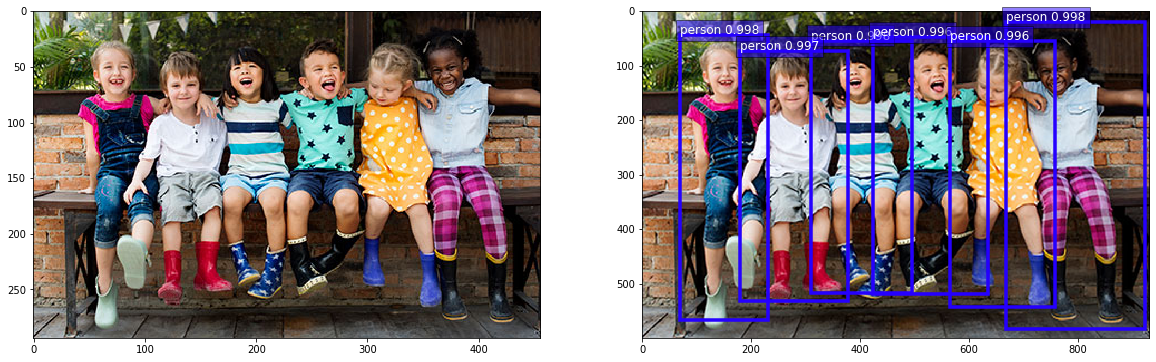

CPU times: user 19.6 s, sys: 661 ms, total: 20.3 s
Wall time: 10.8 s


In [0]:
%%time
x, orig_img = data.transforms.presets.rcnn.load_test(input_image) # do image pre processing
box_ids, scores, bboxes = object_detetcion_net(x) # detect objects 
im_array = np.asarray(Image.open(input_image) ) # load the original image as array
fig = plt.figure(figsize=(20, 20)) # plt the images 
ax1 = fig.add_subplot(2,2,1)
plt.imshow(im_array) # show the original image
ax2 = fig.add_subplot(2,2,2)
utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=object_detetcion_net.classes, ax=ax2) # show the ouput images
plt.show()
gc.collect()

## 2. Image Segmentation(Sementic)

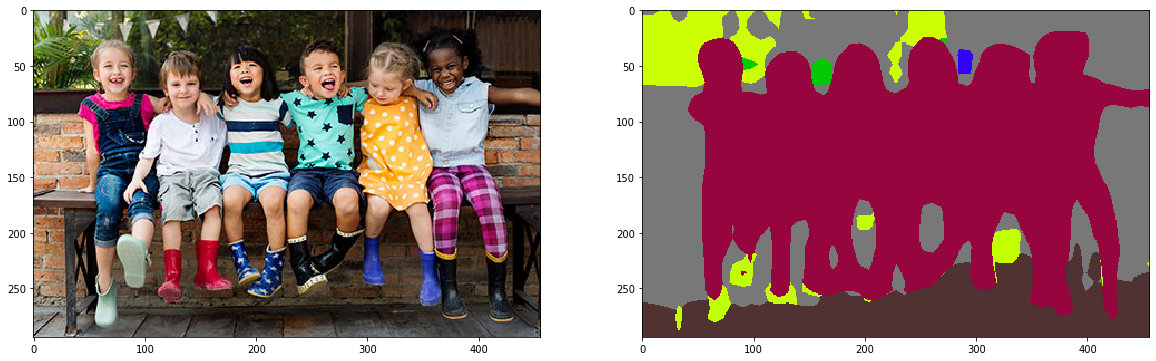

CPU times: user 7.44 s, sys: 161 ms, total: 7.6 s
Wall time: 4.49 s


In [0]:
%%time
ctx = mx.cpu(0)
img = image.imread(input_image)
img = test_transform(img, ctx)


output = segment_net.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()


mask = get_color_pallete(predict, 'ade20k')
mask.save('output.png')
mmask = mpimg.imread('output.png')

im_array = np.asarray(Image.open(input_image) )
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
plt.imshow(im_array)
ax2 = fig.add_subplot(2,2,2)
plt.imshow(mmask)
plt.show()
gc.collect()

## 3. Object Detection + Image Segmentation(Instance)

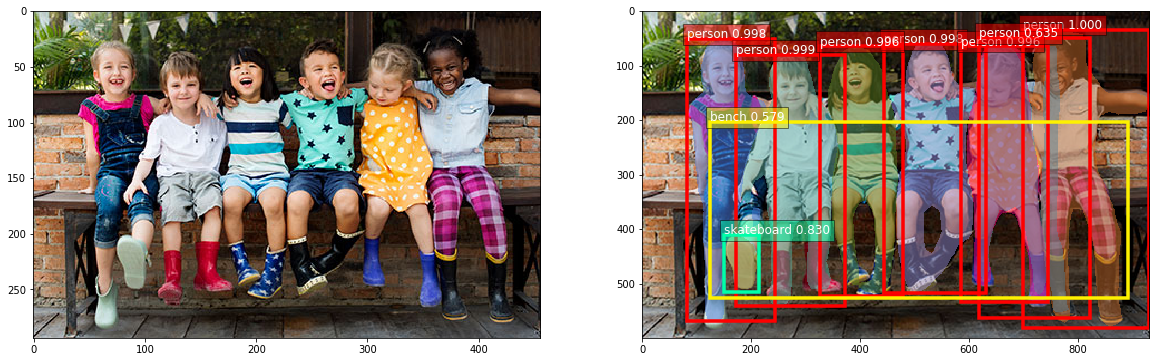

CPU times: user 1min 52s, sys: 1.86 s, total: 1min 54s
Wall time: 58 s


In [0]:
%%time
x, orig_img = data.transforms.presets.rcnn.load_test(input_image)

ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in mask_net(x)]

# paint segmentation mask on images directly
width, height = orig_img.shape[1], orig_img.shape[0]
masks, _ = utils.viz.expand_mask(masks, bboxes, (width, height), scores)
orig_img = utils.viz.plot_mask(orig_img, masks)

# identical to Faster RCNN object detection
im_array = np.asarray(Image.open(input_image) )
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
plt.imshow(im_array)
ax2 = fig.add_subplot(2,2,2)
utils.viz.plot_bbox(orig_img, bboxes, scores, ids,
                         class_names=mask_net.classes, ax=ax2)
plt.show()
gc.collect()

## Lets also visualize the indivisual mask that the network identified 

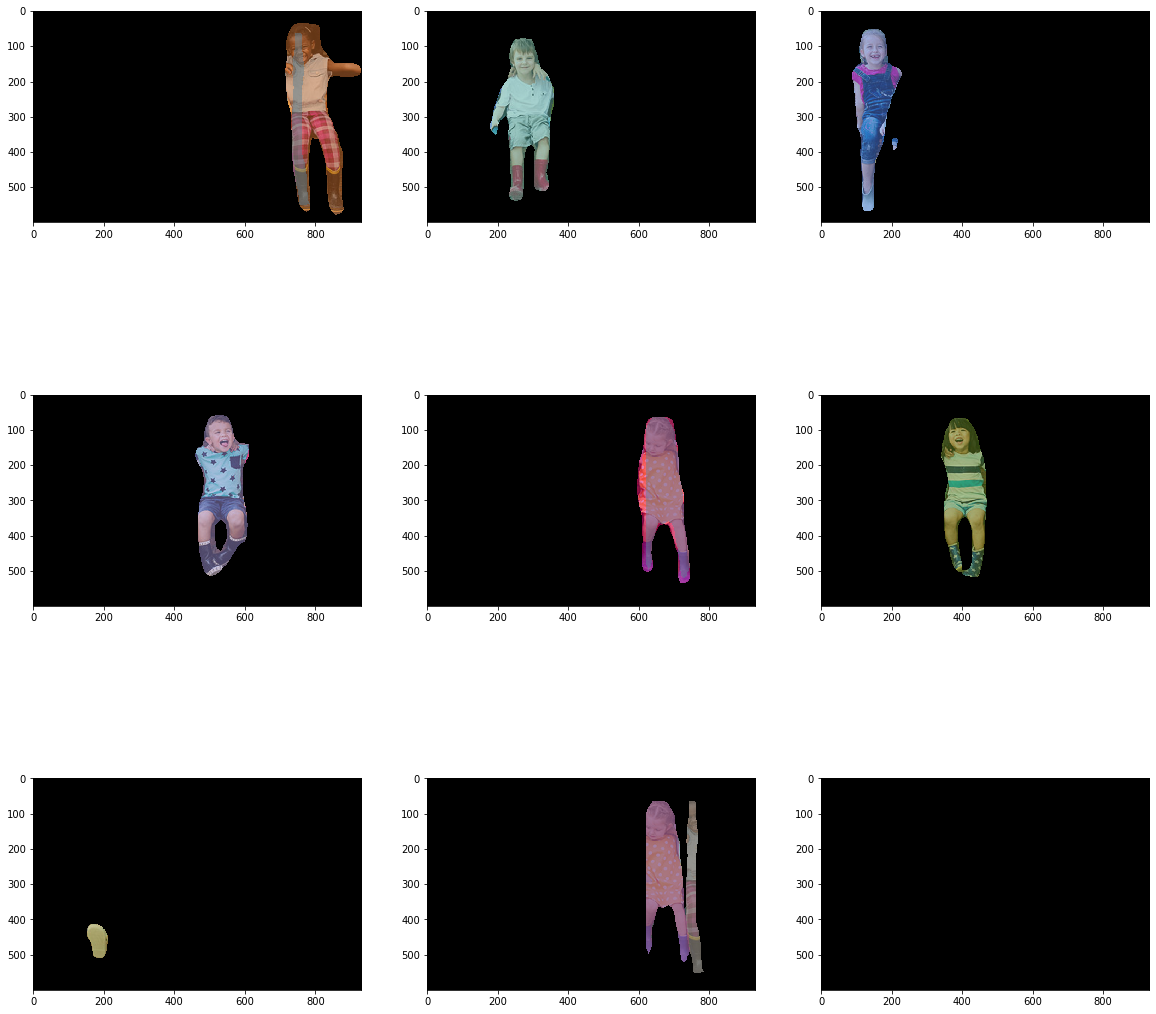

In [0]:
masks = masks.astype(int)
masks.shape

fig, axs = plt.subplots(3,3, figsize=(20, 20))
axs = axs.ravel()

for i in range(masks.shape[0]):
    temp = np.copy(orig_img)
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * masks[i,:,:]
    axs[i].imshow(temp)

# 4. Live Demonstration using webcam feed

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

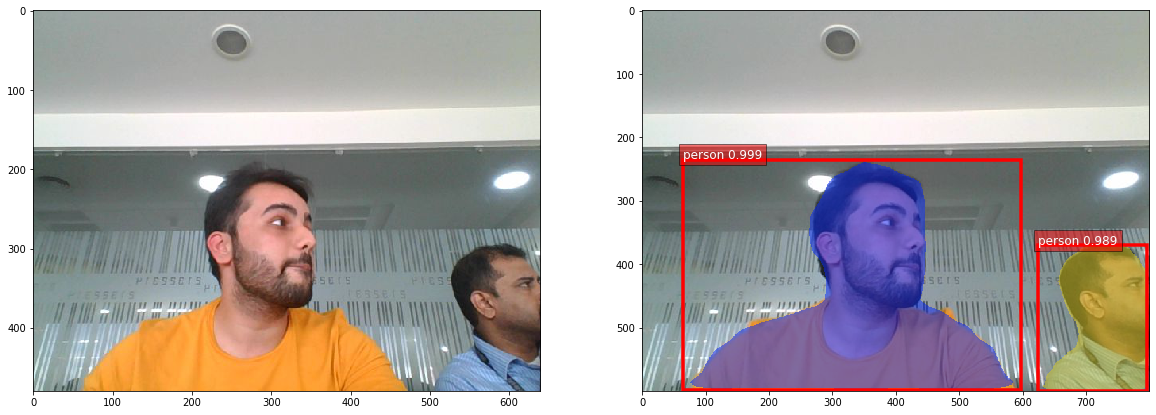

CPU times: user 1min 55s, sys: 1.74 s, total: 1min 57s
Wall time: 1min 6s


In [0]:
%%time
take_photo(input_image)
mask_net = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained=True)
x, orig_img = data.transforms.presets.rcnn.load_test(input_image)

ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in mask_net(x)]

# paint segmentation mask on images directly
width, height = orig_img.shape[1], orig_img.shape[0]
masks, _ = utils.viz.expand_mask(masks, bboxes, (width, height), scores)
orig_img = utils.viz.plot_mask(orig_img, masks)

# identical to Faster RCNN object detection
im_array = np.asarray(Image.open(input_image) )
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
plt.imshow(im_array)
ax2 = fig.add_subplot(2,2,2)
utils.viz.plot_bbox(orig_img, bboxes, scores, ids,
                         class_names=mask_net.classes, ax=ax2)
plt.show()
gc.collect()

# Training custom model using the pretrained weight from COCO to identify car damage

The aim is to build a custom Mask R-CNN model that can detect the area of damage on a car ,such a model can be used by insurance companies for faster processing of claims if users can upload pics and they can assess damage from them. This model can also be used by lenders if they are underwriting a car loan especially for a used car.

### Data Collection

The data was collected by pulling the images of damaged cars from Google. A total of 66 images were collected out of which 50 would be used for train and 16 for validation

### Data Annotation

A Mask R-CNN model requires the user to annotate the images and identify the region of damage. The annotation tool used is the VGG Image Annotator — v 1.0.6. You can use the html version available at this [Link](http://www.robots.ox.ac.uk/~vgg/software/via/via-1.0.6.html). Using this tool you can create a polygon mask as shown below:



<figure>
<center>
<img src='https://i1.wp.com/cdn-images-1.medium.com/max/1000/1*0xHX4FRHM_12Vd4T9IVuFw.png?zoom=1.1875&ssl=1' />
</center>
</figure>

Once you have created all the annotations, you can download the annotation and save it in a json format.



### Model Training

The dataset, annotation and the code to train the model is added in the following github location, you simply need to clone it and run the corresponding cell to kick start the training process

In [0]:
%%capture
! git clone https://github.com/Mohit2008/Object-Detection/
  
data_path ="Object-Detection/customImages/"
log_dir="Object-Detection/logs/"
script_location = "Object-Detection/custom.py"

In [0]:
! python3 {script_location} train --dataset={data_path} --weights=coco --logs={log_dir}

Using TensorFlow backend.
Weights:  coco
Dataset:  Object-Detection/customImages/
Logs:  Object-Detection/logs/

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0

### Model Inference

In [0]:
import os
import sys
import random
import math
import re
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches


ROOT_DIR = os.getcwd()
cust_dir=os.path.join(ROOT_DIR, "Object-Detection")
sys.path.append(cust_dir)

from mrcnn import utils as mrcnn_utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import tensorflow as tf
import custom

%matplotlib inline

MODEL_DIR = os.path.join(cust_dir, "new_dir/logs/")
custom_WEIGHTS_PATH = "mask_rcnn_damage_model.h5"

Using TensorFlow backend.


In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Configurations

In [0]:
config = custom.CustomConfig()

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
    
    
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

Loading weights  mask_rcnn_damage_model.h5


In [0]:
custom_DIR = os.path.join(cust_dir, "customImages")
# Load validation dataset
dataset = custom.CustomDataset()
dataset.load_custom(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 15
Classes: ['BG', 'damage']


### Perform model inference

image ID: damage.image75.jpeg (1) /content/Object-Detection/customImages/val/image75.jpeg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
CPU times: user 3.63 s, sys: 1.45 s, total: 5.07 s
Wall time: 9.04 s


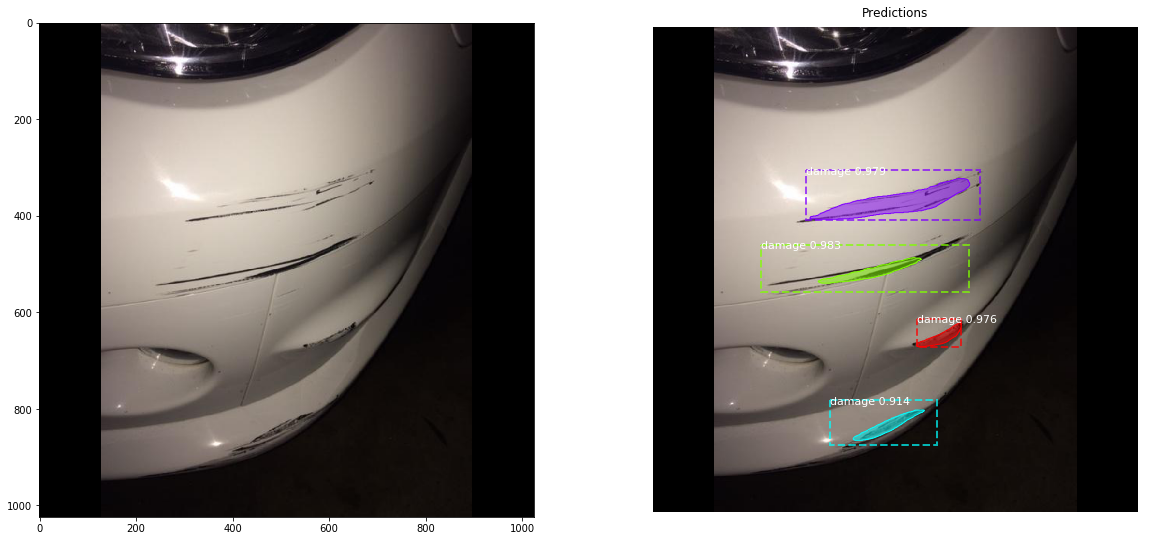

In [0]:
%%time
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, 0, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
#ax = get_ax(1)
r = results[0]

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
plt.imshow(image)
ax2 = fig.add_subplot(2,2,2)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax2,
                            title="Predictions")
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)

## Model inference on a new image from internet

In [0]:
%%capture

image_url_1 = "https://image.shutterstock.com/image-photo/scratched-car-260nw-501242851.jpg"
input_image= "new_damage_car_image.jpg"
! wget --output-document={input_image} {image_url_1}

im_array = np.asarray(Image.open(input_image))
im_array, window, scale, padding, crop = mrcnn_utils.resize_image(
        im_array,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


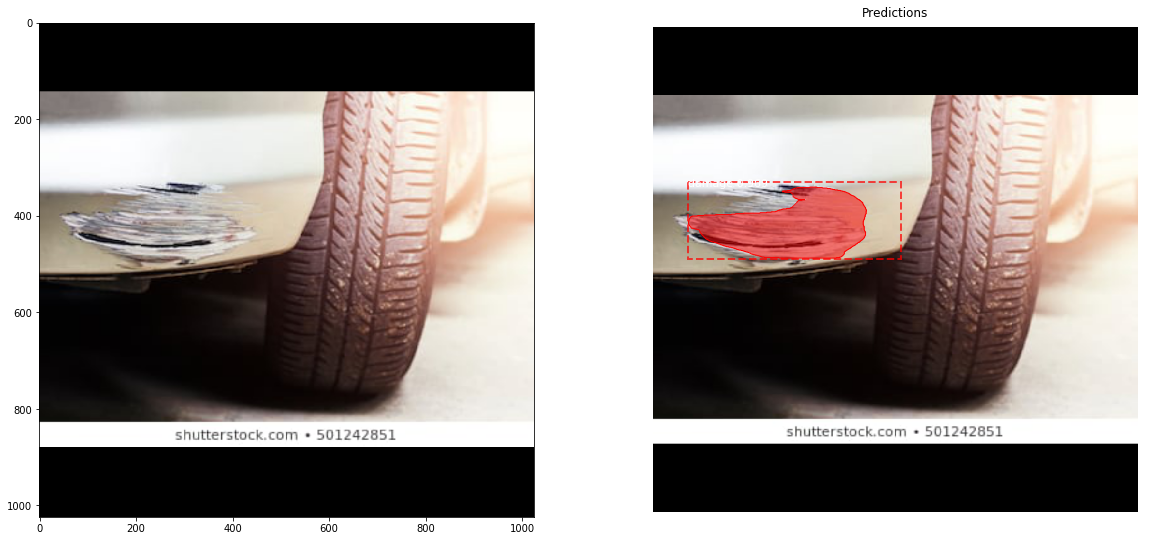

CPU times: user 1.1 s, sys: 227 ms, total: 1.32 s
Wall time: 1.17 s


In [0]:
%%time
results = model.detect([im_array], verbose=1)

# Display results
#ax = get_ax(1)
r = results[0]

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
plt.imshow(im_array)
ax2 = fig.add_subplot(2,2,2)
visualize.display_instances(im_array, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax2,
                            title="Predictions")
plt.show()

<figure>
<center>
<img src='https://media.giphy.com/media/l3q2FnW3yZRJVZH2g/giphy.gif' />
</center>
</figure>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
! cp drive/My\ Drive/mask_rcnn_damage_model.h5 .